In [101]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2
from time import time
import pandas as pd
import seaborn as sns
import argparse
from scipy import signal
import skfuzzy as fuzz
from skimage.exposure import rescale_intensity

In [116]:
## Configure some general styling
sns.set_style("white")
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['figure.figsize'] = (8,7)
colors = ['b', 'orange', 'g', 'r', 'c', 'm', 'y', 'k', 'Brown', 'ForestGreen']

In [103]:
def show_plane(ax, plane, cmap="viridis", title=None):
    ax.imshow(plane, cmap=cmap)
    ax.set_xticks([])
    ax.set_yticks([])
    
    if title:
        ax.set_title(title)
        
    # Define the necessary functions
def getTheFile(filename,rows,cols,start,stop):
    from denpy import DEN
    arr = np.empty([rows, cols, 0])    
    for i in range(start,stop,1):
        Frame = DEN.getFrame(filename, i, row_from=None, row_to=None, col_from=None, col_to=None)
        dentoarr = np.asarray(Frame)
        dentoarr = np.expand_dims(dentoarr, axis=2)
        arr = np.concatenate((arr, dentoarr), axis=2)
    return arr

# Helper function for plotting histograms.
def plot_hist(ax, data, title=None):
    ax.hist(data.ravel(), bins=256)
    ax.ticklabel_format(axis="y", style="scientific", scilimits=(0, 0))
    
    if title:
        ax.set_title(title)

In [104]:
def ExtractTissueByGMM(img3d,clustersNumber):
    from sklearn.mixture import GaussianMixture as gmm
    arr = np.empty([550, 550, 0]) 
    orginalShape =img3d.shape
    reshaped = img3d.reshape(-1,1)
    print("computing gmm model and fitting")
    gmm_model_CTa= gmm(n_components = clustersNumber, covariance_type='tied').fit(reshaped)
    print("Predicitng the labels")
    gmm_labels =gmm_model_CTa.predict(reshaped)
    segmented_frames= gmm_labels.reshape(orginalShape[0],orginalShape[1],orginalShape[2])
    arr = np.concatenate((arr, segmented_frames), axis=2)
    arr = arr.astype(int)
    return arr

def MyCC3d(labeledarr,originalarr):
    import cc3d
    from skimage import segmentation,measure,morphology
    print("computing cc3d")
    labels_out = cc3d.connected_components(labeledarr)
    print("removing small size objects to decrease the output labels")
    interior_labels = morphology.remove_small_objects(labels_out, min_size=300)
    print("relabelling")
    relabeled, _, _ = segmentation.relabel_sequential(interior_labels)
    print("computing the objects properties")
    regionprops = measure.regionprops(relabeled, intensity_image=originalarr)
    print("Computing the areas")
    areas = [regionprop.area for regionprop in regionprops]
    return relabeled,regionprops,areas

def computeAvgDraw(frames):
    print("calculating the average from each frame")
    yvalues =[]
    xvalues = range(frames.shape[2])
    for i in range(frames.shape[2]):
        avg = np.average(frames[:,:,i]!= 0)
        yvalues.append(avg)
    
    print("Average is computed and you can use the xvalues and yvalues to draw the time attenuation curve")
    return xvalues,yvalues

In [105]:
#Getting the 3D-array and 2D-TestingFrame for CT 
print("File is loading ")
Carm_ICA = getTheFile("KVA_carm.den",550,550,173,217)
print("File is loaded with the shape: ",Carm_ICA.shape)
#Normalize the data  
print("Normalizing the data") 
normalized = (Carm_ICA-Carm_ICA.min())/(Carm_ICA.max()-Carm_ICA.min())

File is loading 
File is loaded with the shape:  (550, 550, 44)
Normalizing the data


In [106]:
ICA = ExtractTissueByGMM(normalized,3)

computing gmm model and fitting
Predicitng the labels


In [108]:
relabeled,regionprops,areas = MyCC3d(ICA,Carm_ICA)

computing cc3d
removing small size objects to decrease the output labels
relabelling
computing the objects properties
Computing the areas


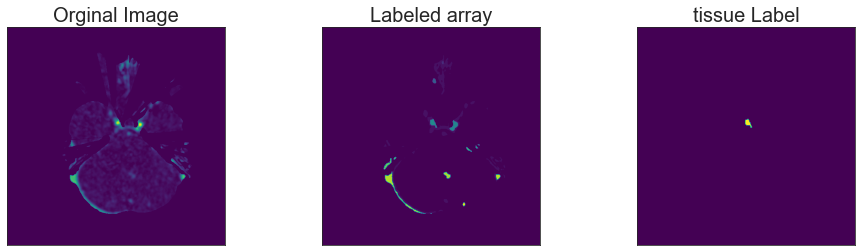

In [109]:
_, (a, b,c) = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
show_plane(a, Carm_ICA[:,:,1], title="Orginal Image", cmap="viridis")
show_plane(b, relabeled[:,:,1], title="Labeled array", cmap="viridis")
show_plane(c, relabeled[:,:,1]==21, title="tissue Label", cmap="viridis")

In [110]:
print("labels: {}".format(np.unique(relabeled[:,:,1])))
for i in range(len(np.unique(relabeled[:,:,1]))):
    print("area: {}".format(areas[i]))

labels: [ 0  2  6 13 20 21 29 32 34 38 39 40 44]
area: 377
area: 258771
area: 520
area: 456
area: 10690
area: 369
area: 749
area: 649
area: 432
area: 1902
area: 611
area: 380
area: 346


In [111]:
L_ICA_mask = relabeled==20
L_ICA = Carm_ICA * L_ICA_mask
R_ICA_mask = relabeled==21
R_ICA = Carm_ICA * R_ICA_mask


In [112]:
 xvalues_L, yvalues_L = computeAvgDraw(L_ICA)
 xvalues_R, yvalues_R = computeAvgDraw(R_ICA)

calculating the average from each frame
Average is computed and you can use the xvalues and yvalues to draw the time attenuation curve
calculating the average from each frame
Average is computed and you can use the xvalues and yvalues to draw the time attenuation curve


Showing the time attenuation curve, close to continue
 The time attenuation curve as pdf and png are saved in your hard disc


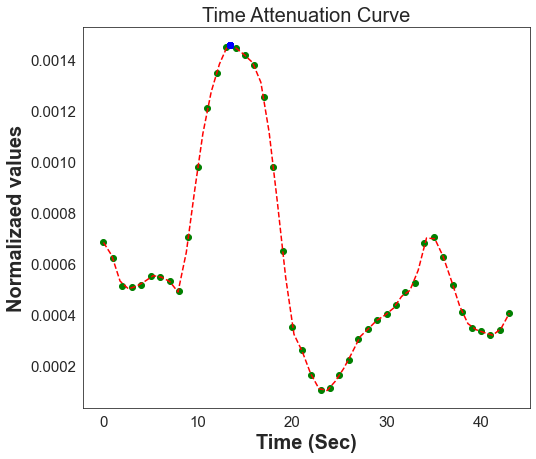

Maximum concentration = 0.0025289572952
Time to peak = 10.988766608
area = 0.04935416800572


In [113]:
from gekko import GEKKO
xvalues = np.linspace(0,ICA.shape[2]-1,num=ICA.shape[2])
#GEKKO model
p=GEKKO()
#Parameter
xspline = p.Param(value=np.linspace(0,ICA.shape[2]-1))
#Variable
yspline = p.Var()
p.cspline(xspline,yspline,xvalues,yvalues_R)
pxx=p.Var(value=1 ,lb=10,ub=16)
pyy=p.Var()
p.Obj(-pyy)
p.cspline(pxx,pyy,xvalues,yvalues_R)
#Regression Mode
p.options.IMODE = 2
#Optimize
p.solve(disp=False)
print(" Showing the time attenuation curve, close to continue")
fig1 = plt.gcf()
plt.title('Time Attenuation Curve')
plt.plot(xvalues,yvalues_R,'go',label='data')
plt.plot(xspline,yspline,'r--',label='cubic spline')
plt.plot(pxx,pyy,'bo',label='maximum')
plt.ylabel('Normalizaed values')
plt.xlabel('Time (Sec)')
fig1.savefig("selectedVessel.pdf")
fig1.savefig("selectedVessel.png")
print(" The time attenuation curve as pdf and png are saved in your hard disc")
plt.show()
print("Maximum concentration =", str(py.VALUE[1]))
print("Time to peak =", str(px.VALUE[1]))
from numpy import trapz
# Compute the area using the composite trapezoidal rule.
area = trapz(myspline)
print("area =", area)

Showing the time attenuation curve, close to continue
 The time attenuation curve as pdf and png are saved in your hard disc


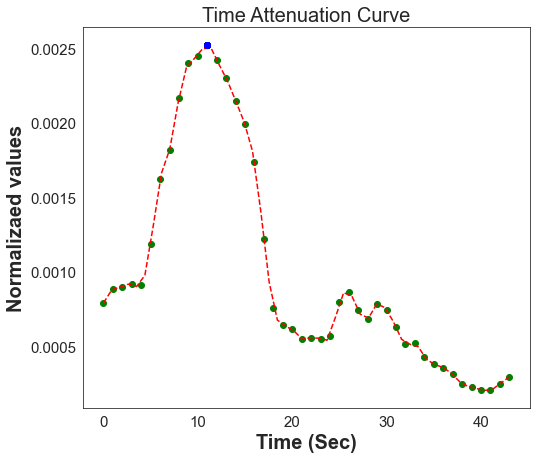

Maximum concentration = 0.0025259301062
Time to peak = 10.991485069
area = 0.04931652922063


In [114]:
from gekko import GEKKO
xvalues = np.linspace(0,ICA.shape[2]-1,num=ICA.shape[2])
#GEKKO model
m=GEKKO()
#Parameter
mxspline = m.Param(value=np.linspace(0,ICA.shape[2]-1))
#Variable
myspline = m.Var()
m.cspline(mxspline,myspline,xvalues,yvalues_L)
px=m.Var(value=1 ,lb=10,ub=16)
py=m.Var()
m.Obj(-py)
m.cspline(px,py,xvalues,yvalues_L)
#Regression Mode
m.options.IMODE = 2
#Optimize
m.solve(disp=False)
print(" Showing the time attenuation curve, close to continue")
fig1 = plt.gcf()
plt.title('Time Attenuation Curve')
plt.plot(xvalues,yvalues_L,'go',label='data')
plt.plot(mxspline,myspline,'r--',label='cubic spline')
plt.plot(px,py,'bo',label='maximum')
plt.ylabel('Normalizaed values')
plt.xlabel('Time (Sec)')
fig1.savefig("selectedVessel.pdf")
fig1.savefig("selectedVessel.png")
print(" The time attenuation curve as pdf and png are saved in your hard disc")
plt.show()
print("Maximum concentration =", str(py.VALUE[1]))
print("Time to peak =", str(px.VALUE[1]))
from numpy import trapz
# Compute the area using the composite trapezoidal rule.
area = trapz(myspline)
print("area =", area)

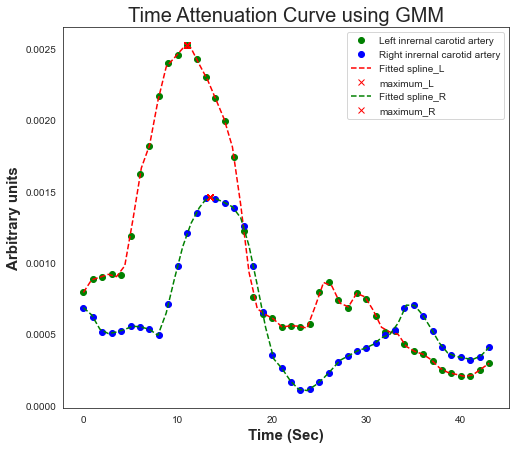

In [117]:
fig2 = plt.gcf()
plt.title('Time Attenuation Curve using GMM')

plt.plot(xvalues,yvalues_L,'go',label='Left inrernal carotid artery')
plt.plot(xvalues,yvalues_R,'bo',label='Right inrernal carotid artery')
plt.plot(mxspline,myspline,'r--',label='Fitted spline_L')
plt.plot(px,py,'rx',label='maximum_L')


plt.plot(xspline,yspline,'g--',label='Fitted spline_R')
plt.plot(pxx,pyy,'rx',label='maximum_R')
plt.ylabel('Arbitrary units')
plt.xlabel('Time (Sec)')
plt.legend()

In [65]:
# save DEN fILE 
def saveDENfile(arr):
    DEN.writeEmptyDEN("arr", arr.shape[0], arr.shape[1],arr.shape[2], force=True)
    for i in range(arr.shape[2]):
        dcm = arr[:,:,i]
        DEN.writeFrame('arr', i, dcm, force=True)

In [72]:
from pyevtk.hl import imageToVTK
import numpy as np
imageToVTK('volume', pointData={'value' : L_ICA})    # create volume.vti
imageToVTK('volume', pointData={'value' : R_ICA})    # create volume.vti

'e:\\02.Python_Projects\\01.BrainSegmentaion\\volume.vti'